![berlin-307382_1280.png](https://cdn.pixabay.com/photo/2014/04/02/16/28/berlin-307382_1280.png)


# Udacity Project "Explore Weather Trends"


* Author: Christian Altmoos 
* First project of the "Data Analysist Nanodegree" Program of Udacity
* Summary:
  In this project, you will analyze local and global temperature data and compare the temperature trends where you     live to overall global temperature trends.
* Tools used: SQL and jupyter notebook (python)

# Get data from Udacity SQL workspace

As I'm living in Germany I will have a look on Germanies capital city **Berlin**.

* First check if "Berlin" is in the dataset
  
  SQL: SELECT COUNT ( \* ) FROM city_list WHERE city = 'Berlin'
  
  Result: count 1 
  

* Yes, very good. Now check number of records of city_data

  SQL: SELECT COUNT ( \* ) FROM city_data WHERE city = 'Berlin'
  
  Result: count 271
  
  
* Check the number of results of global_data

  SQL: SELECT COUNT ( \* ) FROM global_data
  
  Result: count 266
  
  
* So we see there is slight mismatch so it makes sense to select all city data for Berlin and global data in a full     join. The data can be cleaned later if there is a need.
  
  SQL:
      
      SELECT           city.year AS year, 
                       city.city AS city, 
                       city.country AS country, 
                       city.avg_temp AS city_avg_temp,  
                       global.year AS global_year, 
                       global.avg_temp AS global_avg_temp            
      FROM             city_data city
      FULL OUTER JOIN  global_data global  
      ON               city.year = global.year  
      WHERE            city.city = 'Berlin'  
      
  Result: count 271

The result if the last SQL I downloaded to **result.csv**

# Load Libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data 

Load the data previously downloaded into results.csv. We use pandas read_csv.

In [46]:
try:
    city_data = pd.read_csv('results.csv')      
except Exception as er:
    print(str(er)) 
print(city_data.shape)

(271, 6)


Ok, everything all right, 271 records, 6 columns. Let's continue ...

## NA handling

As we saw in the SQL session before there is mismatch of the 2 data sources. The full join might also produced NA values. So let's examine them and decide what to do.

### Count NA records 

In [47]:
city_data.isnull().sum()

year               0
city               0
country            0
city_avg_temp      4
global_year        7
global_avg_temp    7
dtype: int64

Not too much values are missing let's have a closer look.

### Display NA records

In [48]:
print(city_data[city_data.isnull().any(axis=1)])

   year    city  country  city_avg_temp  global_year  global_avg_temp
0  1743  Berlin  Germany           6.33          NaN              NaN
1  1744  Berlin  Germany          10.36          NaN              NaN
2  1745  Berlin  Germany           1.43          NaN              NaN
3  1746  Berlin  Germany            NaN          NaN              NaN
4  1747  Berlin  Germany            NaN          NaN              NaN
5  1748  Berlin  Germany            NaN          NaN              NaN
6  1749  Berlin  Germany            NaN          NaN              NaN


Seems to be at the beginning of the time series there was an isseu. The easiest way now to handle those NA records, is to get rid of them! :-)

### Delete NAs from the time series
Drop those records directly in the dataset. Also drop the column global_year as it is so to say keeping double information.

In [49]:
city_data.dropna(inplace=True)
city_data.drop(labels='global_year', axis=1,inplace=True)

### Quick check if it worked
Just to be sure count again the count of NAs.

In [50]:
city_data.isnull().sum()

year               0
city               0
country            0
city_avg_temp      0
global_avg_temp    0
dtype: int64

The weather data are now adjusted and cleansed. Now we can step into the analysis.

# Weather Trend Analysis
## Compute the moving average

Calculate the moving average. Now the question is, how to choose the window for the moving average calculation. I was researching a bit (actually not too much). The website [climate4you.com](https://www.climate4you.com/DataSmoothing.htm) is describing that. They have chosen a **3 years** window. However 3 years was still a bit too noisy. After some variations I descided to multply that by 10, hence I used **30 years** as rolling window.
For the calculation itself I use pandas [rolling](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html). The rolling method "slices" the data based on a window and one can apply any pandas method on top it. Like the mean calculation in our case.

In [51]:
# rolling window calculation 
constWindow = 30
city_data = city_data.assign(city_mov_avg=city_data['city_avg_temp'].rolling(window=constWindow).mean())
city_data = city_data.assign(global_mov_avg=city_data['global_avg_temp'].rolling(window=constWindow).mean())

## Summary of data 

In [52]:
print(city_data.describe())

              year  city_avg_temp  global_avg_temp  city_mov_avg  \
count   264.000000     264.000000       264.000000    235.000000   
mean   1881.500000       8.917727         8.359394      8.866226   
std      76.354437       0.883601         0.575184      0.292501   
min    1750.000000       4.840000         5.780000      8.437000   
25%    1815.750000       8.357500         8.077500      8.649167   
50%    1881.500000       8.935000         8.365000      8.789333   
75%    1947.250000       9.485000         8.700000      9.017000   
max    2013.000000      10.960000         9.730000      9.851667   

       global_mov_avg  
count      235.000000  
mean         8.313193  
std          0.348127  
min          7.706333  
25%          8.095667  
50%          8.192333  
75%          8.634500  
max          9.270667  


The data seems to be average temparatures of Berlin compared to the rest if the of the worls seems to be close. But if you look closer it is different. 

* Max temp in Berlin (city_avg_temp) 10,96°C. Compared to 9,73°C globally. More than one degree! Taking current discussions into account 1 degree increase in temparature can cause natural disasters
* The Berlin temparature (Standard Deviation: 0,85) is more varialbe then the Global Temparature (Standard Deivation: 0,55)

Let's have a visual look on both temparature distributions.

## Plot Boxplots for Average Temparature


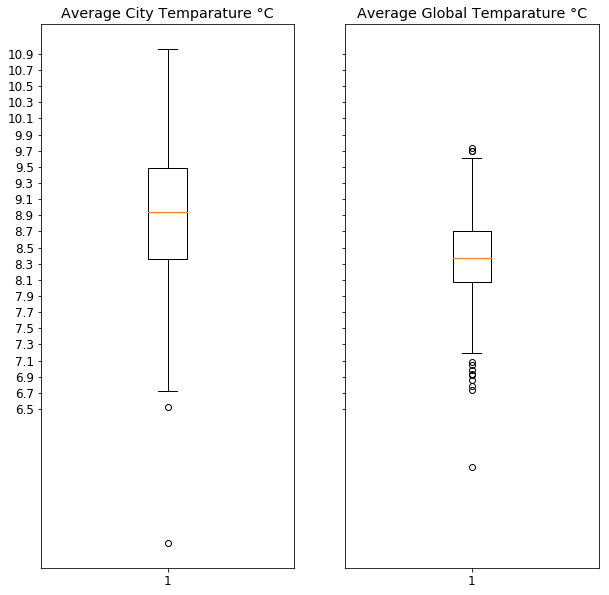

In [53]:
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10), sharex='col', sharey='row')
axs[0].boxplot(city_data['city_avg_temp'])
axs[0].set_title('Average City Temparature °C')
axs[0].yaxis.set_ticks(np.arange(6.5,11,0.1))
axs[1].boxplot(city_data['global_avg_temp'])
axs[1].set_title('Average Global Temparature °C')
axs[1].yaxis.set_ticks(np.arange(6.5,11,0.2))
plt.show()

The boxplots are underlining that fact:

* The spread of Berlin is much wider than the global one 
* Globally we have far more outliers (values outside the upper and the lower whisker) 
* The interquartile range (upper and lower 25% around the median) for Berlin is appr. 8,35°C - 9,45°C. The global one ranges from appr. 7,15°C - 8,7°C. 

## Plot the data 

Let's plot the data using matplotlib.pyplot. I scatter the yearly observations and put the smoothed lines on top, to see the original values (and the spread) together with the smoothed lines.

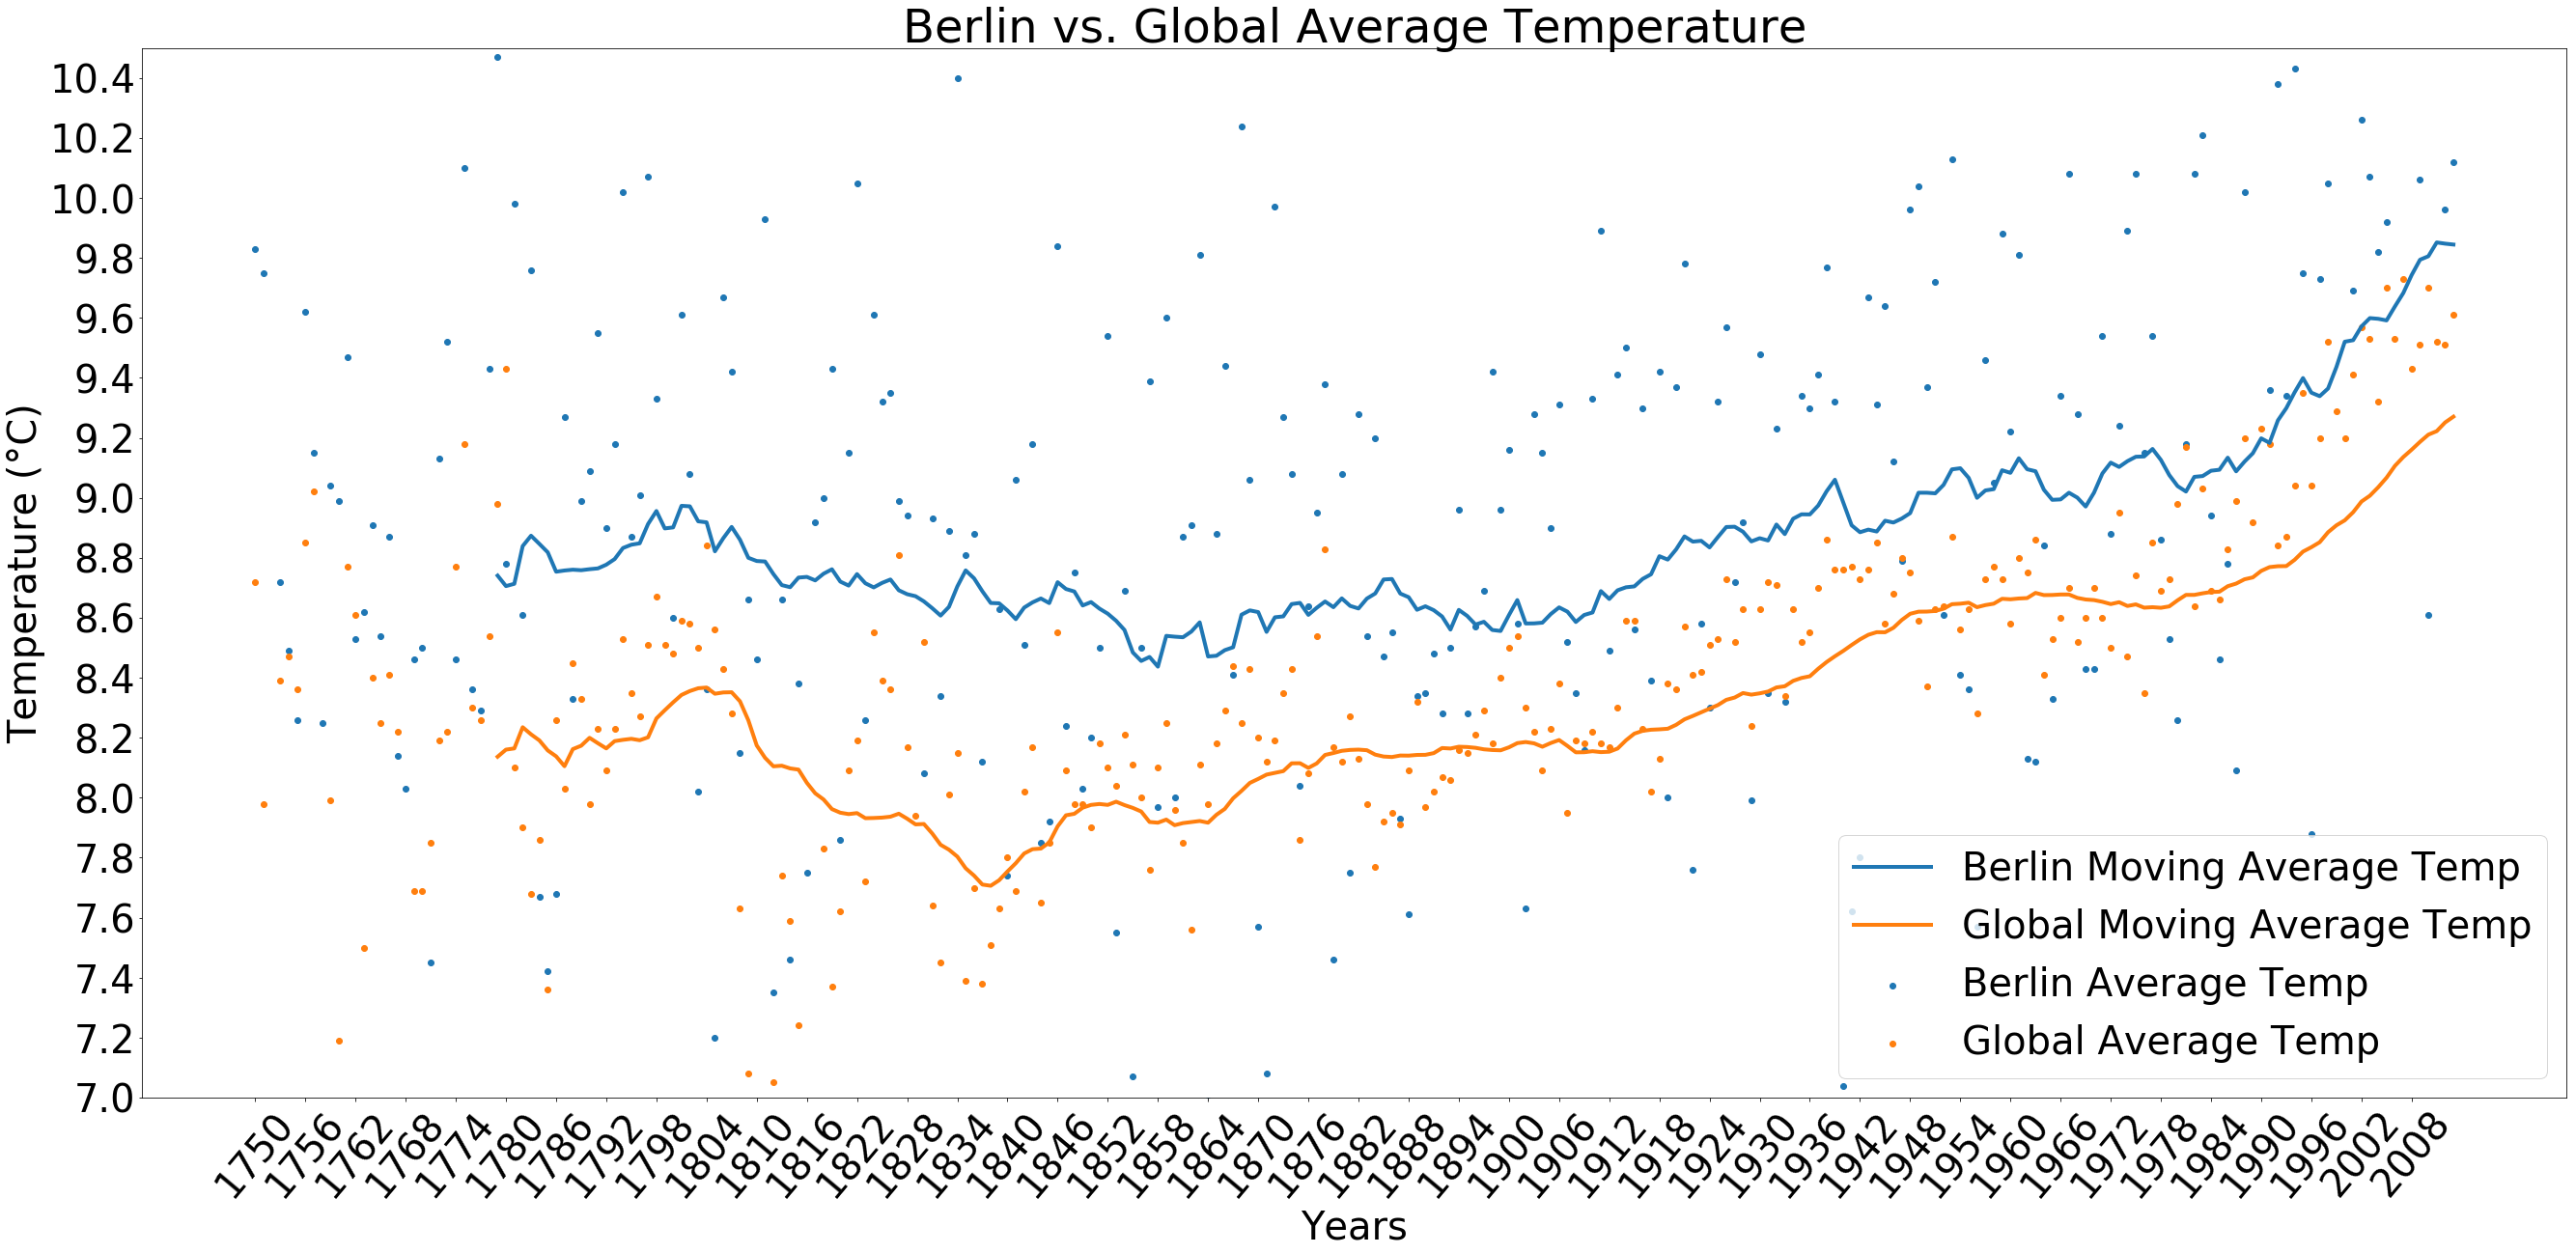

In [54]:
plt.rcParams.update({'font.size': 40})
plt.figure(figsize=(45,20))
plt.plot(city_data['year'], city_data['city_mov_avg'], label = 'Berlin Moving Average Temp',linewidth=4, markersize=12)
plt.scatter(city_data['year'], city_data['city_avg_temp'], label = 'Berlin Average Temp ')
plt.plot(city_data['year'], city_data['global_mov_avg'],label = 'Global Moving Average Temp',linewidth=4, markersize=12)
plt.scatter(city_data['year'], city_data['global_avg_temp'], label = 'Global Average Temp ')
plt.legend()
plt.xlabel("Years")
plt.ylabel("Temperature (°C)")
plt.title("Berlin vs. Global Average Temperature")
plt.xticks(np.arange(min(city_data['year']), max(city_data['year']), 6))
plt.ylim(bottom = 7, top = 10.5)
plt.yticks(np.arange(7, 10.5, step=0.2))
plt.xticks(rotation=50)
plt.show()

Ok looks like we have an isseu.

* It's clearly visible beginning of, I would say starting around. 1838 there is a steady
increase in temparature
* In the beginning of the 1980's the level of increase was growing dramatically
* In the early centuries appr. till the mid of 19th century there were huge variantions globally. 
    * e.g. the huge drop in 1838 globally to an avg. temparature of appr. 7.7 °C
    * this seems to be more stable in Berlin the drop was indeed her the oppisite a slight increase
* The two time series seems to be pretty much corralated, which not necessarily mean it has a causal relationship. 

Let's look to the last couple of years beginning with 1980 for the global moving average temparature.

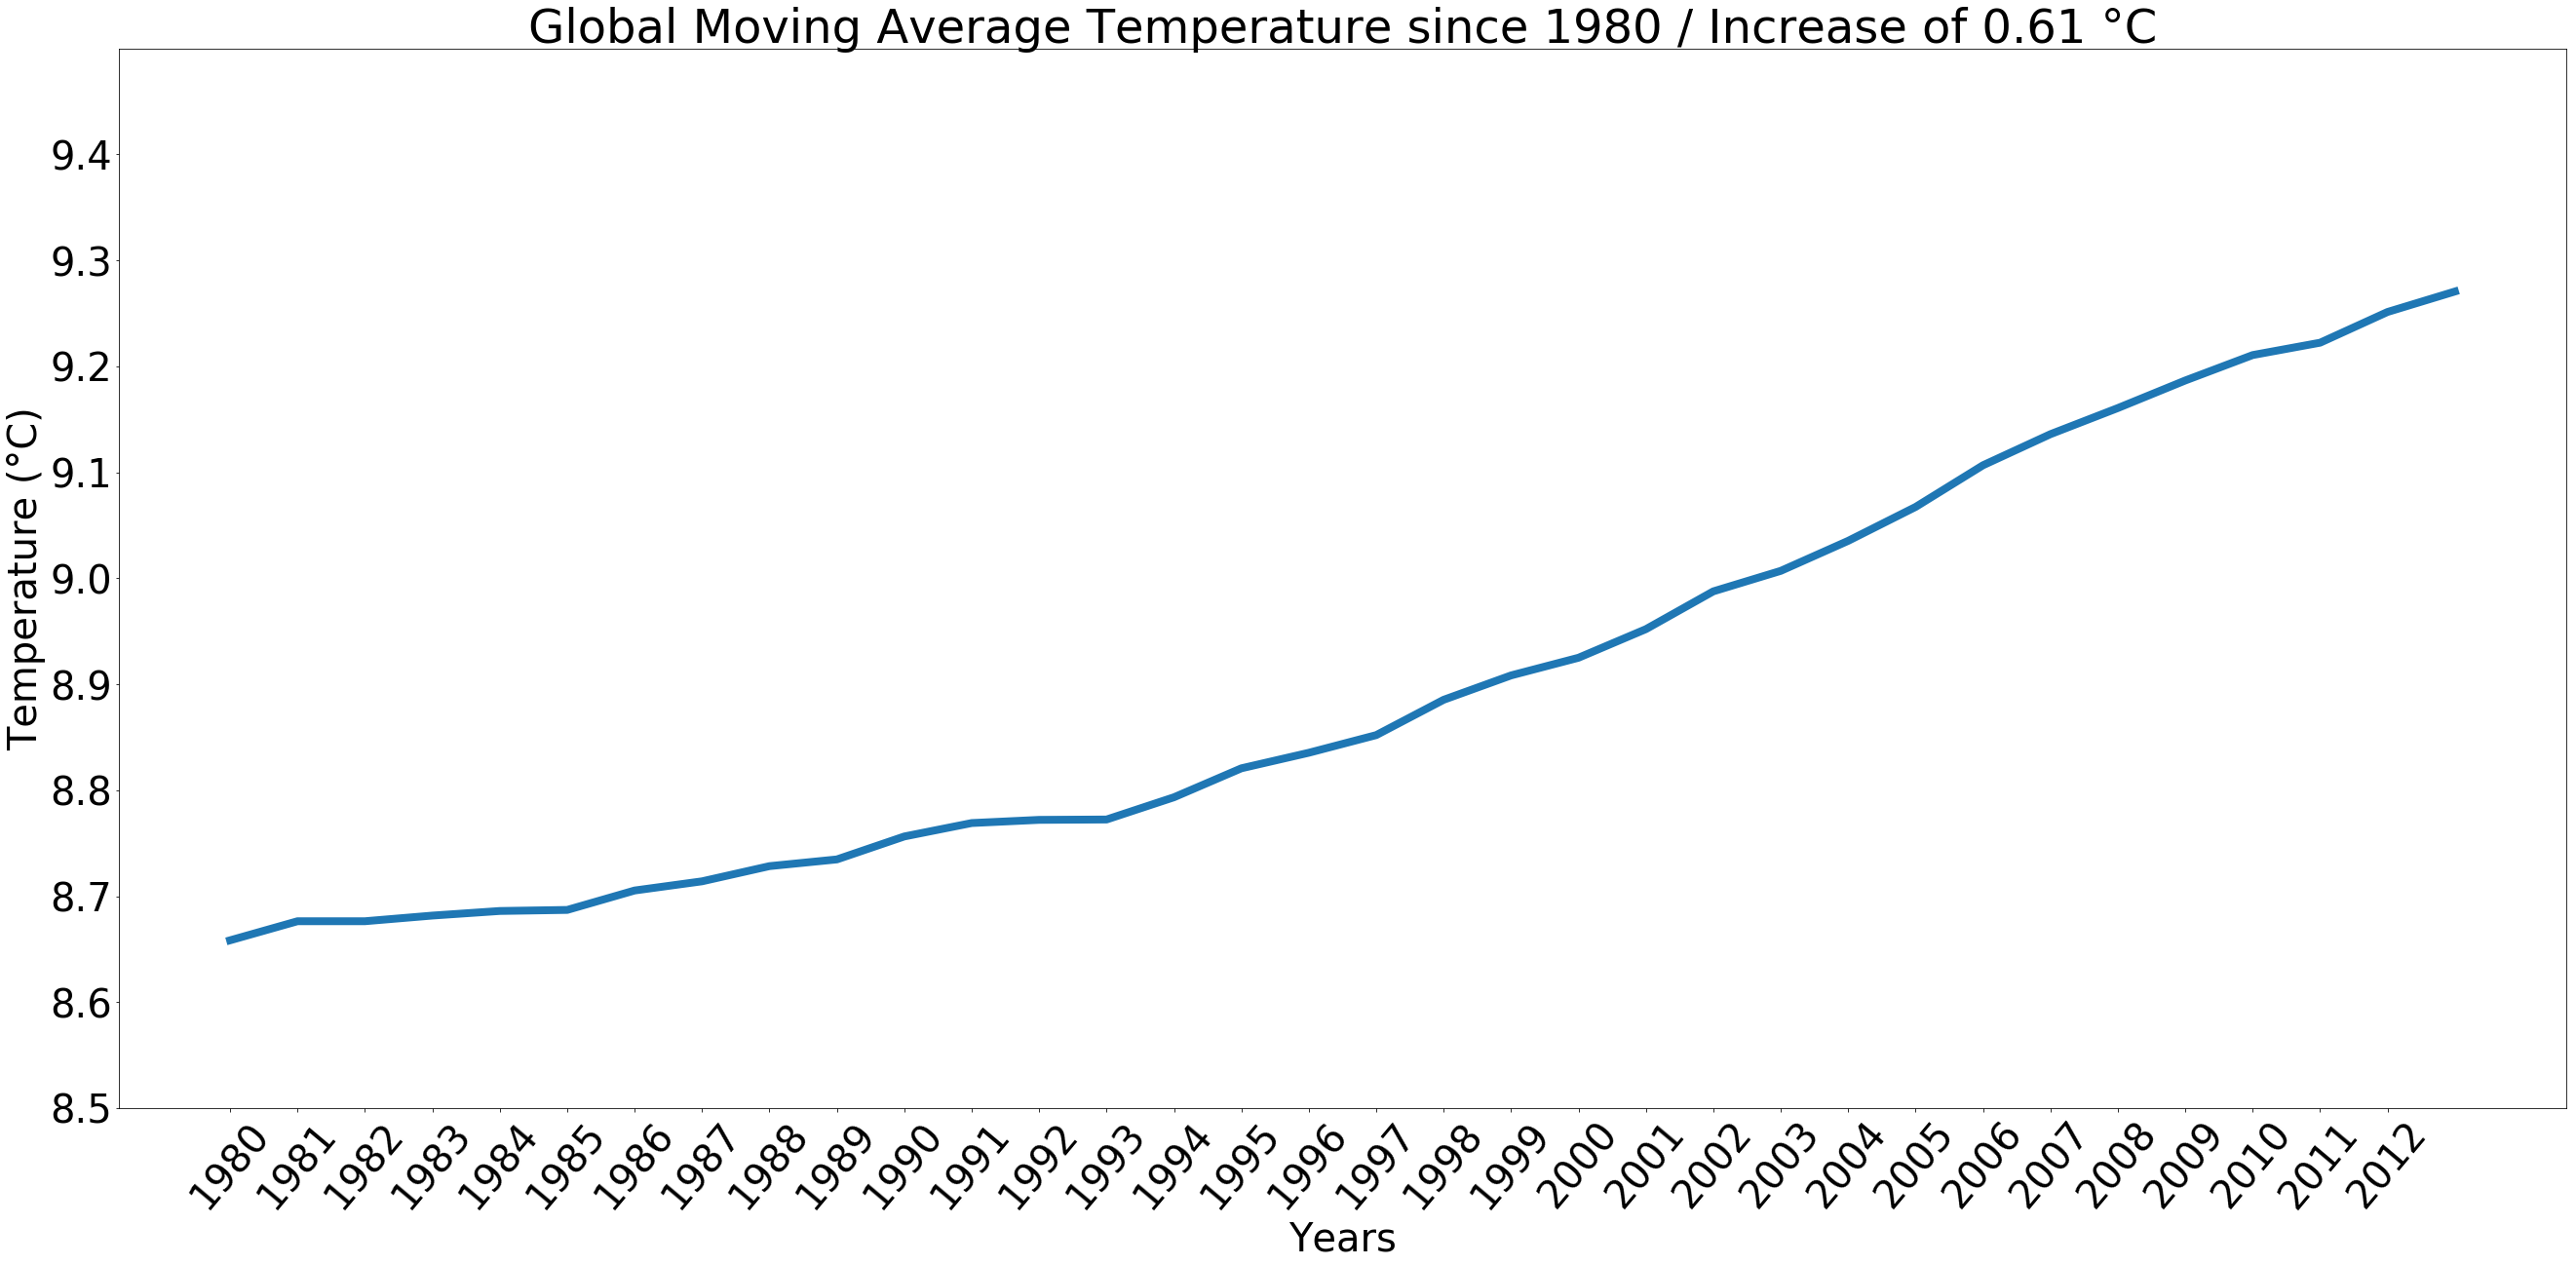

In [55]:
plt.rcParams.update({'font.size': 40})
city_data = city_data.loc[(city_data['year'] >= 1980)]
temp_1980 = city_data.global_mov_avg.min()
temp_2012 = city_data.global_mov_avg.max()
temp_diff = temp_2012 - temp_1980
plt.figure(figsize=(45,20))
plt.plot(city_data['year'], city_data['global_mov_avg'],linewidth=8, markersize=12)
plt.xlabel("Years")
plt.ylabel("Temperature (°C)")
plt.title("Global Moving Average Temperature since 1980 / Increase of {} °C".format(str('%.2f' % round(temp_diff,2))))
plt.xticks(np.arange(min(city_data['year']), max(city_data['year']), 1))
plt.ylim(bottom = 8.5, top = 9.5)
plt.yticks(np.arange(8.5, 9.5, step=0.1))
plt.xticks(rotation=50)
plt.show()

## Four Key Observations Summary
1. The city data of **Berlin** is basically **more noisy** then global data. This might be due to the fact that the global data set is kind of syndication of different temparature extremes all over the world which are balancing each other out.
2. It's a bit **warmer** in **Berlin** compared to the global average. The mean of the un-smoothed Berlin **avg. temparature** is **8,93 Celsius** compared to the Global avg. temparature of **8,36 Celsius**. The respective **maximums** are **10,96 Celsius** in Berlin and **9,73 Celsius** globally.
3. There is beginning appr. with **1838** a **steady increase** in temparature, might be the negative effects of pollution already caused by the "Industrial Revolution" (which started in the late 1700's)
4. Beginning of the **1980** the **slope** of the temparature (both locally and globally) gets **steeper**, due to us as human beings. The **increase** globally from **1980 to 2012** is **0,61 °C**. 